# Classification report for models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
fer = pd.read_csv("../fer2013/fer2013.csv")

In [3]:
fer.pixels = fer.pixels.apply(lambda i: np.fromstring(i, sep=' '))
emotion = {0:'Angry',1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotionList = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Suprise', 'Neutral']

In [4]:
train = fer[['emotion','pixels']][fer['Usage']=='Training']
public_test = fer[['emotion','pixels']][fer['Usage']=='PublicTest']
private_test = fer[['emotion','pixels']][fer['Usage']=='PrivateTest']

In [5]:
def Xy(xy):
    """
    Returns pixels, respective emotions.
    """
    return np.vstack(xy.pixels.values), np.array(xy.emotion)

In [6]:
X_train,y_train = Xy(train)
X_private_test,y_private_test = Xy(private_test)
X_public_test,y_public_test = Xy(public_test)

In [7]:
def reshape(imgr):
    """
    Returns reshaped image (48x48).
    """
    return imgr.reshape(-1,48,48,1)

In [8]:
X_train = X_train.reshape(-1,48,48,1)
X_public_test = reshape(X_public_test)
X_private_test = reshape(X_private_test)

In [9]:
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [10]:
import glob
import os
import collections

list_of_models = {}
for h5_model in glob.glob('../Models/*.h5'):
    neural_net_name = os.path.basename(h5_model)
    if neural_net_name == 'fer_base_V1_CNN.h5':
        neural_net_name = 'Base Neural Network'
    elif neural_net_name == 'fer_base_V4_CNN.h5':
        neural_net_name = 'Deep Neural Network'
    elif neural_net_name == 'fer_base_Deep_V2_CNN.h5':
        neural_net_name = 'Deep Neural Network with more hidden layers and nodes'
    elif neural_net_name == 'fer_Deep_BN_V3_CNN.h5':
        neural_net_name = 'Deep Neural Network with more hidden layers, nodes and Batch Normalization'
    list_of_models[neural_net_name]=load_model(h5_model)

In [11]:
models = collections.OrderedDict(sorted(list_of_models.items()))

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [13]:
def plot_classification_report(cr, show_cr=False, show_plot=True, title='Classification Report'):
    """
    Function prints out a classification report and plots the report.
    """
    if show_cr:
        print(cr)
    if not show_plot:
        return
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    plt.figure(figsize = (10,8))
    plt.imshow(plotMat, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(emotionList))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, emotionList)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [14]:
def plot_confusion_matrix(cm, show_cm=False, title='Confusion Matrix'):
    """
    Function prints out confusion matrix and plots the matrix.
    """
    if show_cm:
        print(cm)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j], va='center', ha='center')
    ax.set_xticklabels(['']+emotionList, rotation=45)
    ax.set_yticklabels(['']+emotionList)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
b_model = models['Deep Neural Network with more hidden layers, nodes and Batch Normalization']
b_cm = confusion_matrix(y_public_test, b_model.predict_classes(X_public_test))
b_cr = classification_report(y_public_test, b_model.predict_classes(X_public_test), target_names=emotionList)

[[214   4  58  44  78  15  54]
 [  9  29   5   4   5   1   3]
 [ 52   5 180  21 121  57  60]
 [ 40   4  46 695  21  22  67]
 [ 92   3  71  46 301  24 116]
 [  7   0  37  18  12 327  14]
 [ 59   1  56  45  90  16 340]]


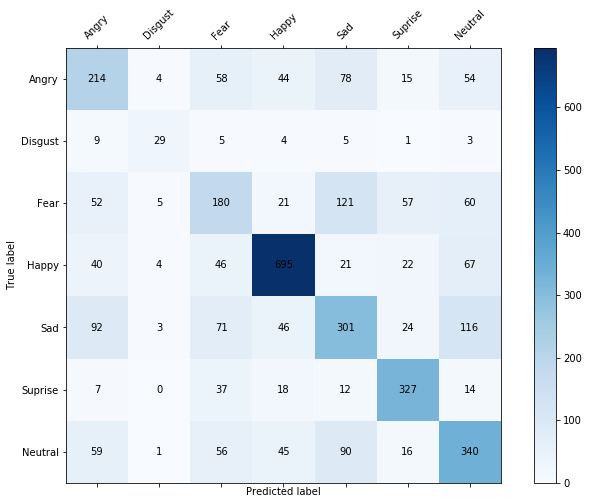

In [16]:
plot_confusion_matrix(b_cm, True)

             precision    recall  f1-score   support

      Angry       0.45      0.46      0.46       467
    Disgust       0.63      0.52      0.57        56
       Fear       0.40      0.36      0.38       496
      Happy       0.80      0.78      0.79       895
        Sad       0.48      0.46      0.47       653
    Suprise       0.71      0.79      0.75       415
    Neutral       0.52      0.56      0.54       607

avg / total       0.58      0.58      0.58      3589



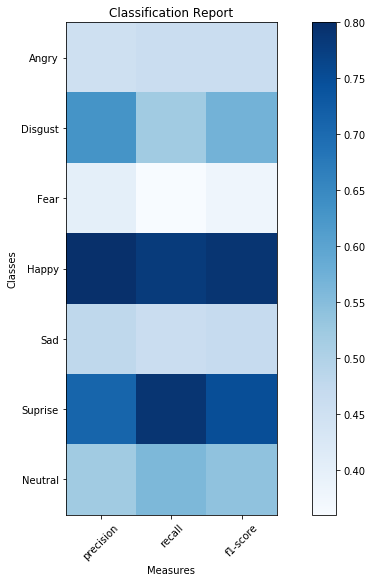

In [17]:
plot_classification_report(b_cr, True)

In [18]:
def get_prob_pred_true(model_):
    """
    Function returning probability, prediction, true label using the provided model.
    """
    prob = model_.predict(X_public_test)
    pred = [np.argmax(prb) for prb in prob]
    true = [np.argmax(true) for true in y_public_test]
    return prob, pred, true

In [19]:
y_prob, y_pred, y_true = get_prob_pred_true(b_model)

In [20]:
def show_images(start,end):
    """
    Shows range of images from Public test set.
    """
    plt.figure(0, figsize=(12,8))
    for i in range(start,end+1):
        plt.subplot(5,5,i+1)
        plt.imshow(X_public_test[i, :, :, 0], cmap='gray')
        plt.grid(False)
        plt.axis('off')
        plt.title(emotion[y_public_test[i]])
    plt.tight_layout()
    plt.show()

In [21]:
def show_probs(start,end):
    """
    Function plots the probabilities bar graph.
    """
    fig = plt.figure(0, figsize=(12,8))
    for i in range(start, end+1):
        ax = fig.add_subplot(5,5,i+1)
        ax.bar(np.arange(0,7), y_prob[i], color='grey')
        ax.set_xticks(np.arange(0,7))
        ax.set_xticklabels(emotionList, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.title(emotion[y_pred[i]])
        plt.tight_layout()
    plt.show()

In [22]:
def show_img_prob_plots(n):
    """
    Function shows image with probabilities of expressions.
    """
    for i in range(1,n):
        show_images(i*n,(i+1)*n-1)
        show_probs(i*n, (i+1)*n-1)
    plt.show()

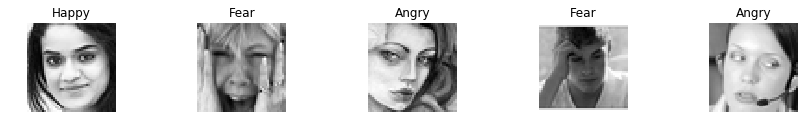

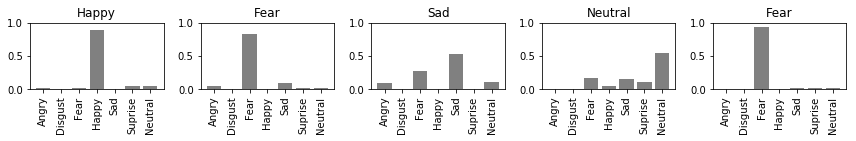

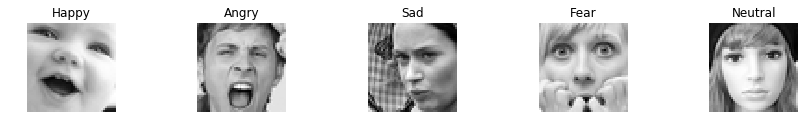

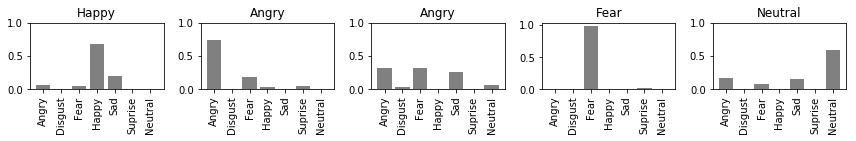

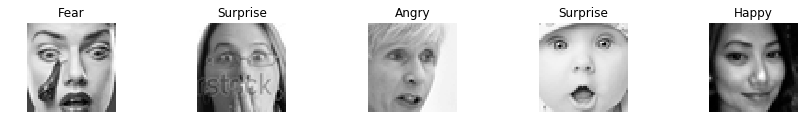

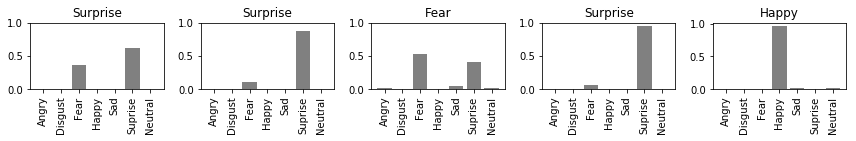

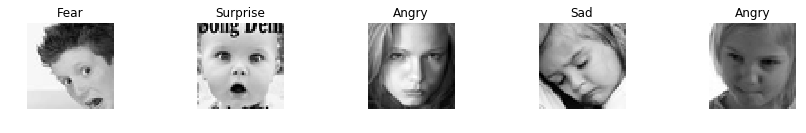

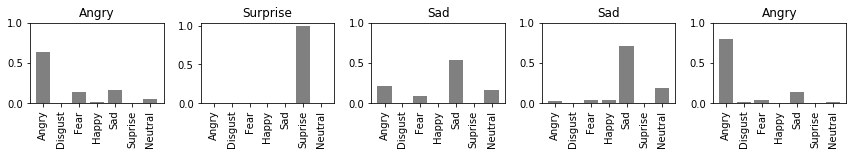

In [23]:
show_img_prob_plots(5)

In [24]:
from keras import backend as K

def show_model_conv(inp=0,oup=0):
    """
    Function shows model's convolution.
    """
    get_layer_output = K.function([b_model.layers[inp].input],
                                      [b_model.layers[oup].output])
    layer_output = get_layer_output([X_public_test])[0]
    #print (layer_output.shape)
    n_filters = layer_output.shape[1]
    fig = plt.figure(figsize=(12,8))
    #print(n_filters)
    for i in range(n_filters):
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(layer_output[0,i,:,:], cmap='Blues')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

## Visualization of Inner Convolutional Neural Net.

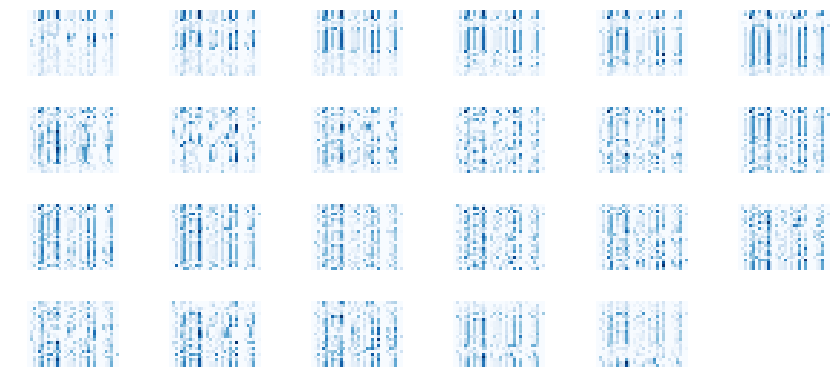

In [25]:
show_model_conv(0,0)

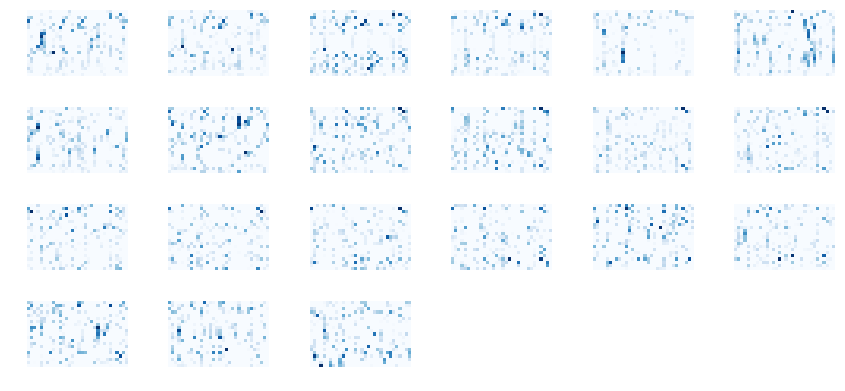

In [26]:
show_model_conv(0,2)

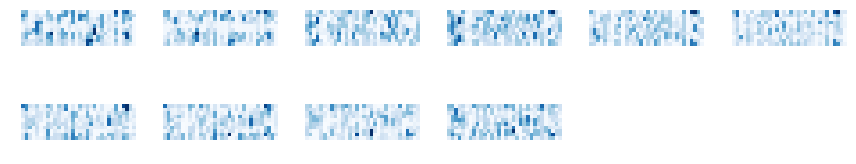

In [27]:
show_model_conv(0,4)

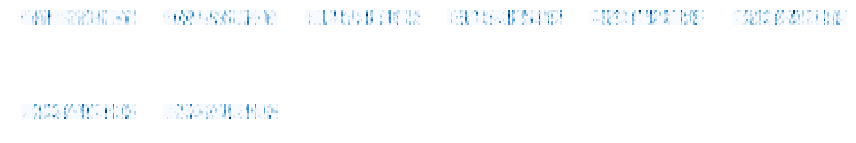

In [28]:
show_model_conv(0,8)

## Above are model visions after convolutions.

In [29]:
b_score = b_model.evaluate(X_public_test, to_categorical(y_public_test), verbose=0)

In [30]:
print('Loss:',b_score[0],'\nAccuracy','{:.2%}'.format(b_score[1]))

Loss: 1.2274824164 
Accuracy 58.12%


In [31]:
def show_classification_header():
    print('-'*60)
    print('CLASSIFICATION REPORT FOR EACH EXPRESSION ON PUBLIC TEST SET.')
    print('-'*60)
    print('EXPRESSION\tPRECISION\tRECALL\t\tF-SCORE')
    print('-'*60)

def show_class_report(model_):
    """
    Function to show classification report metrics for a given class.
    """
    show_classification_header()
    y_prob, y_pred, y_true = get_prob_pred_true(model_)
    for emotion_ in range(0,7):
        precision,recall,fscore,support=score(y_public_test, y_pred)
        print (emotionList[emotion_],'      ',
               '\t{:.3%}'.format(precision[emotion_]),
               '\t{:.3%}'.format(recall[emotion_]),
               '\t{:.3%}'.format(fscore[emotion_]))

In [32]:
#show_class_report(b_model)

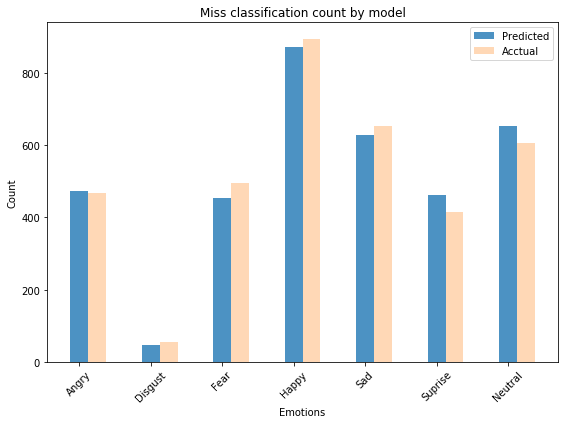

In [33]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(emotionList)))
fig, ax = plt.subplots(figsize=(8,6))
w = 0.25
indicies = np.arange(7)
pred_lbls = ax.bar(indicies, np.bincount(y_pred), w, alpha=0.8)
true_lbls = ax.bar(indicies + w, np.bincount(y_public_test), w, alpha=0.3)
ax.set_xticklabels(['']+emotionList, rotation=45)
plt.title('Miss classification count by model')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.legend(('Predicted','Acctual'))
plt.tight_layout()
plt.show()

## Comparison with different neural nets.

In [34]:
def show_different_class_report(emotion_):
    """
    Function prints out each class classification report.
    """
    print('-'*80)
    print('NEURAL NET\tEXPRESSION\t\tPRECISION\tRECALL\t\tF-SCORE')
    print('-'*80)
    print('\t\t',emotionList[emotion_])
    print('-'*80)
    for model_name, model in models.items():
        y_prob, y_pred, y_true = get_prob_pred_true(model)
        precision,recall,fscore,support=score(y_public_test, y_pred)
        print (model_name,'\n\t\t\t',
               '\t\t{:.2%}'.format(precision[emotion_]),
               '\t\t{:.2%}'.format(recall[emotion_]),
               '\t\t{:.2%}'.format(fscore[emotion_]))
        print('-'*80)      

In [35]:
show_different_class_report(0)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Angry
--------------------------------------------------------------------------------
Base Neural Network 
			 		37.37% 		38.33% 		37.84%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		46.55% 		50.54% 		48.46%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		41.02% 		46.47% 		43.57%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		45.24% 		45.82% 		45.53%
--------------------------------------------------------------------------------


In [36]:
show_different_class_report(1)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Disgust
--------------------------------------------------------------------------------
Base Neural Network 
			 		60.00% 		5.36% 		9.84%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		77.78% 		25.00% 		37.84%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		80.00% 		14.29% 		24.24%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		63.04% 		51.79% 		56.86%
--------------------------------------------------------------------------------


In [37]:
show_different_class_report(2)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Fear
--------------------------------------------------------------------------------
Base Neural Network 
			 		36.25% 		17.54% 		23.64%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		46.26% 		19.96% 		27.89%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		42.70% 		15.32% 		22.55%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		39.74% 		36.29% 		37.93%
--------------------------------------------------------------------------------


In [38]:
show_different_class_report(3)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Happy
--------------------------------------------------------------------------------
Base Neural Network 
			 		67.00% 		66.70% 		66.85%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		77.86% 		74.64% 		76.21%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		77.90% 		77.21% 		77.55%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		79.61% 		77.65% 		78.62%
--------------------------------------------------------------------------------


In [39]:
show_different_class_report(4)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Sad
--------------------------------------------------------------------------------
Base Neural Network 
			 		37.72% 		43.49% 		40.40%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		43.75% 		46.09% 		44.89%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		41.31% 		53.14% 		46.48%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		47.93% 		46.09% 		46.99%
--------------------------------------------------------------------------------


In [40]:
show_different_class_report(5)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Suprise
--------------------------------------------------------------------------------
Base Neural Network 
			 		62.63% 		71.08% 		66.59%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		70.02% 		75.42% 		72.62%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		65.81% 		79.76% 		72.11%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		70.78% 		78.80% 		74.57%
--------------------------------------------------------------------------------


In [41]:
show_different_class_report(6)

--------------------------------------------------------------------------------
NEURAL NET	EXPRESSION		PRECISION	RECALL		F-SCORE
--------------------------------------------------------------------------------
		 Neutral
--------------------------------------------------------------------------------
Base Neural Network 
			 		40.40% 		49.92% 		44.66%
--------------------------------------------------------------------------------
Deep Neural Network 
			 		43.41% 		61.29% 		50.82%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers and nodes 
			 		49.22% 		52.06% 		50.60%
--------------------------------------------------------------------------------
Deep Neural Network with more hidden layers, nodes and Batch Normalization 
			 		51.99% 		56.01% 		53.93%
--------------------------------------------------------------------------------


## Above shows metrics of each Neural Network for different emotions.

In [42]:
def show_emotion(emo):
    """
    Returns emotion after prediction.
    """
    return emotion[np.argmax(emo, axis=None, out=None)]

Originally	 Fear
Predicted as:	 Fear


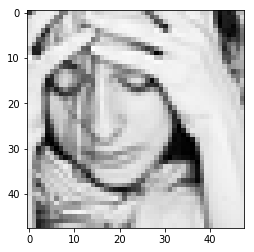

In [43]:
i = 553
plt.imshow(X_public_test[i, :, :, 0], cmap='gray')
print('Originally\t',emotion[y_public_test[i]])
p = b_model.predict(reshape(X_public_test[i]))
print('Predicted as:\t',show_emotion(p))